In [26]:
# data manipulation
import pandas as pd
import numpy as np
from google.colab import drive
import pandas_datareader as pdr

# data preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA

# plotting/visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [27]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
df = pd.read_csv('/content/gdrive/MyDrive/ISAN Project/Datasets/data_all.csv')
df.head()

,Date,Ticker,Sector,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,GDP,IndustrialProduction,UnemploymentRate,NonfarmPayments,AvgHourlyEarnings,CorporateProfitsAfterTax,ConsumerLoans,BankLoansAndLeases,SP500Index,USDIndex
0,2021-01-04 00:00:00-05:00,AMC,Communication Services,22.000000,22.000000,20.000000,20.100000,2987380,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.3243,10340.3132,3700.65,111.2143
1,2021-01-05 00:00:00-05:00,AMC,Communication Services,19.900000,20.299999,19.100000,19.799999,2814830,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.3243,10340.3132,3726.86,110.9649
2,2021-01-06 00:00:00-05:00,AMC,Communication Services,20.299999,22.299999,19.700001,20.100000,6736330,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3748.14,110.8573
3,2021-01-07 00:00:00-05:00,AMC,Communication Services,20.799999,21.100000,20.200001,20.500000,2615050,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3803.79,111.3124
4,2021-01-08 00:00:00-05:00,AMC,Communication Services,20.900000,22.100000,20.700001,21.400000,3955330,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3824.68,111.2930


# Data Cleaning

In [29]:
# create an X dataframe
X = df.copy()

# convert datetime format strings columns to dates
X['Date'] = pd.to_datetime(X['Date'], utc=True).dt.date

In [30]:
"""
Combining the yearly and quarterly metrics

Since the magnitudes for yearly and quarterly aggregates will differ, we will
standardize each feature and combine them.
"""
quarterly_data = [col for col in X.columns if col.endswith('_q')]
yearly_data = [col for col in X.columns if col.endswith('_y')]
new_cols = [col[:-2] for col in quarterly_data]

for col in new_cols:
  # scale each feature
  new_vals = X[[col + '_q', col + '_y']]
  new_col_vals = np.where(np.isnan(new_vals.iloc[:, 0]), new_vals.iloc[:, 1], new_vals.iloc[:, 0])

  # create the new one and drop the old ones
  X.loc[:, col] = new_col_vals
  X.drop(columns=[col + '_q', col + '_y'], inplace=True)

# checking columns
X.columns

Index(['Date', 'Ticker', 'Sector', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock Splits', 'FederalFundsRate', 'PrimeRate',
       '10YrTreasuryRate', 'CPI', 'CoreCPI', 'GDP', 'IndustrialProduction',
       'UnemploymentRate', 'NonfarmPayments', 'AvgHourlyEarnings',
       'CorporateProfitsAfterTax', 'ConsumerLoans', 'BankLoansAndLeases',
       'SP500Index', 'USDIndex', 'TotalRevenue', 'OperatingRevenue',
       'NetIncome', 'NetIncomeCommonStockholders',
       'DilutedNIAvailtoComStockholders', 'DilutedEPS', 'BasicEPS',
       'DilutedAverageShares', 'BasicAverageShares', 'PretaxIncome',
       'TaxProvision', 'NormalizedIncome', 'NetIncomeContinuousOperations',
       'TotalDebt', 'TangibleBookValue', 'InvestedCapital',
       'NetTangibleAssets', 'CommonStockEquity', 'StockholdersEquity',
       'RetainedEarnings', 'CapitalStock', 'CommonStock',
       'TotalLiabilitiesNetMinorityInterest', 'PayablesAndAccruedExpenses',
       'TotalAssets', 'NetPPE', 'CashAn

In [31]:
# get count of rows with null values
X.isnull().sum().where(lambda x: x > 0).dropna().sort_values(ascending=False)

,0
PrimeRate,8730.0
PayablesAndAccruedExpenses,1005.0
RetainedEarnings,755.0
BasicEPS,627.0
DilutedEPS,627.0
DilutedAverageShares,627.0
BasicAverageShares,627.0
InvestedCapital,504.0
NetTangibleAssets,504.0
TotalDebt,504.0


In [32]:
# count of dates where nulls occur vs. count of all dates
print(len(X[X.isna().any(axis=1)]['Date'].unique()))
print(len(X['Date'].unique()))

888
1088


In [33]:
# sorted columns with null values
X.isna().sum().sort_values(ascending=False).where(lambda x: x > 0).dropna()

,0
PrimeRate,8730.0
PayablesAndAccruedExpenses,1005.0
RetainedEarnings,755.0
DilutedAverageShares,627.0
BasicAverageShares,627.0
DilutedEPS,627.0
BasicEPS,627.0
TotalAssets,504.0
TotalLiabilitiesNetMinorityInterest,504.0
StockholdersEquity,504.0


In [34]:
# get FRED data for prime rate
min_date = X[X[['Date', 'PrimeRate']].isna().any(axis=1)]['Date'].min()
max_date = X[X[['Date', 'PrimeRate']].isna().any(axis=1)]['Date'].max()

# print missing min and max dates
print(min_date, max_date)

# get data frame pdr
prime = pdr.DataReader('PRIME', 'fred', min_date, max_date)
prime.columns = ['PrimeRate']

prime.shape

2020-10-01 2022-03-16


(0, 1)

In [35]:
"""
It seems like data does not exist for this date range in pdr.
After researching, it looks like the prime rate was 3.25 for the entire range.
"""

# check for any nulls in prime rate
X['PrimeRate'] = X['PrimeRate'].fillna(3.25)
X['PrimeRate'].isna().sum()

np.int64(0)

In [36]:
# find which subset is missing for the 504
cols_w_504_nan = X.isna().sum() \
  .where(lambda x: x == 504) \
  .dropna() \
  .index.tolist()

print(cols_w_504_nan)

# get date range
dates = X.loc[X[cols_w_504_nan].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

# get distinct set of tickers
tickers = X.loc[X[cols_w_504_nan].isna().any(axis=1)]['Ticker']
print(tickers.unique())

['TotalDebt', 'TangibleBookValue', 'InvestedCapital', 'NetTangibleAssets', 'CommonStockEquity', 'StockholdersEquity', 'CapitalStock', 'CommonStock', 'TotalLiabilitiesNetMinorityInterest', 'TotalAssets', 'NetPPE', 'CashAndCashEquivalents']
2021-01-04 2021-12-31
['XOM' 'GS']


In [37]:
# drop these XOM/GS stocks between this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

In [38]:
# find which subset is missing for the 627
cols_w_627_nan = X.isna().sum() \
  .where(lambda x: x == 627) \
  .dropna() \
  .index.tolist()

print(cols_w_627_nan)

# get date range
dates = X.loc[X[cols_w_627_nan].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

# get distinct set of tickers
tickers = X.loc[X[cols_w_627_nan].isna().any(axis=1)]['Ticker']
print(tickers.unique())

['DilutedEPS', 'BasicEPS', 'DilutedAverageShares', 'BasicAverageShares']
2024-10-01 2025-01-30
['LIN' 'KO' 'GOOGL' 'HD' 'PFE' 'DUK' 'TSLA' 'VZ' 'PLD' 'AMZN']


In [39]:
# drop these instances - we do not need information for this date range,
# as it is not available yet via the API
i_to_drop = X.loc[X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

In [40]:
# payables and accured expenses
dates = X.loc[X[['Date', 'PayablesAndAccruedExpenses']].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

tickers = X.loc[X[['Date', 'PayablesAndAccruedExpenses']].isna().any(axis=1)]['Ticker']
print(tickers.unique())

# drop for this stock in this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

2023-01-03 2024-09-30
['BAC']


In [41]:
# retained earnings
dates = X.loc[X[['Date', 'RetainedEarnings']].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

tickers = X.loc[X[['Date', 'RetainedEarnings']].isna().any(axis=1)]['Ticker']
print(tickers.unique())

# drop for this stock in this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

2024-01-02 2024-09-30
['JNJ']


In [42]:
X.isna().sum().sum()

np.int64(0)

In [43]:
X.shape

(28654, 52)

# Feature engineering and standardization

In [44]:
# normalize/standardize columns
num_cols = X.select_dtypes(include='number').columns

# we picked robust scaler due to right-tailed nature of price data
scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [45]:
# define response variable (close price) and remove highly correlated attributes
y = X['Close']
X.drop(columns=['Close', 'Open', 'High', 'Low'], inplace=True)

# Using PCA to reduce dimensionality

In [46]:
"""
Using PCA to reduce dimensionality
"""
# creating dataset with only numerical attributes for PCA
X_num = X.select_dtypes(include='number')

# conduct PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_num)

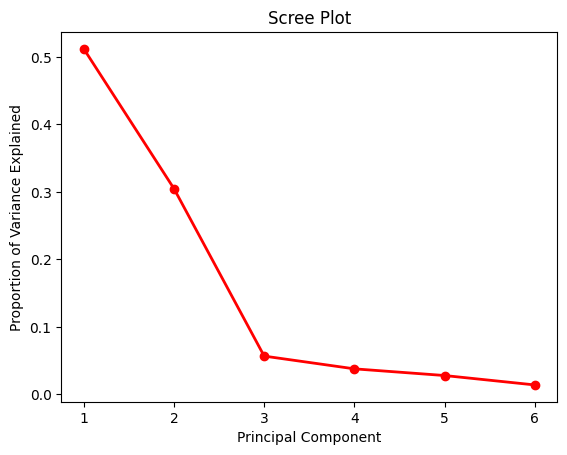

In [47]:
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')

plt.show()

In [48]:
# getting the eigenvectors into a dataframe
eigenvectors_df = pd.DataFrame(
    data=pca.components_.T,
    columns=[f"P{i}" for i in range(1, pca.n_components_ + 1)],
    index=X_num.columns
)

# print eigenvalue for each principal component
print(pca.explained_variance_)

# print cumulative sum of explained variance ratio (we will extract until 0.8)
print(np.cumsum(pca.explained_variance_ratio_))

# print eigenvectors
eigenvectors_df.head()

[91.95035186 54.73706145 10.15478877  6.76382704  4.98360579  2.48050511]
[0.51197753 0.81675228 0.87329392 0.91095476 0.93870337 0.95251477]


,P1,P2,P3,P4,P5,P6
Volume,-0.007621,0.040093,0.926077,-0.108061,0.066166,-0.106228
Dividends,0.000077,-0.000371,-0.001049,0.000126,-0.001093,-0.001915
Stock Splits,0.000021,0.000170,0.000763,-0.000011,-0.000569,0.001603
FederalFundsRate,-0.002086,0.000158,-0.000455,-0.098980,-0.122245,-0.010886
PrimeRate,-0.002083,0.000154,-0.000457,-0.098808,-0.121967,-0.010835


In [49]:
# number of components and index when cumsum reaches 0.8
n_pcs= pca.components_.shape[0]
threshold_index = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(threshold_index)]

# get feature names that influence the principal components the most
most_important_names = [X.columns[most_important[i]] for i in range(threshold_index)]

for i in range(threshold_index):
  print('PC{}: {}'.format(i + 1, most_important_names[i]))

PC1: PayablesAndAccruedExpenses
PC2: StockholdersEquity
PC3: Date
PC4: SP500Index
PC5: CoreCPI
PC6: SP500Index


In [50]:
# combine variables and principal components
df_final = pd.concat([
    X[['Date', 'Ticker', 'Sector']],
    pd.DataFrame(
        X_pca,
        columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)]
    ),
    y
], axis=1)

# verify shapes of X and y are compatible
print(df_final.shape, y.shape)

(28654, 10) (28654,)


In [62]:
# convert 'Date' column to datetime objects
df_final['Date'] = pd.to_datetime(df_final['Date'])

# Now proceed with extracting year, month, day, and weekday
df_final['Year'] = df_final['Date'].dt.year
df_final['Month'] = df_final['Date'].dt.month
df_final['Day'] = df_final['Date'].dt.day
df_final['Weekday'] = df_final['Date'].dt.weekday

# Then drop the original Date column
df_final = df_final.drop(columns=['Date'])

In [63]:
df_final.head()

,Ticker,Sector,PC1,PC2,PC3,PC4,PC5,PC6,Close,Year,Month,Day,Weekday
0,AMC,Communication Services,-5.505606,-1.818654,-1.223541,0.857447,6.446029,1.510964,-0.585921,2021,1,4,0
1,AMC,Communication Services,-5.505592,-1.818956,-1.230224,0.856242,6.449773,1.515877,-0.587640,2021,1,5,1
2,AMC,Communication Services,-5.506768,-1.813064,-1.094167,0.837209,6.460657,1.503236,-0.585921,2021,1,6,2
3,AMC,Communication Services,-5.505951,-1.819224,-1.238742,0.831946,6.433286,1.524149,-0.583629,2021,1,7,3
4,AMC,Communication Services,-5.506416,-1.817210,-1.192533,0.821708,6.435215,1.521338,-0.578472,2021,1,8,4


# XGBoost Model

In [64]:
# create lag feature
def create_lag_features(df, target_column, lags=5):
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    df = df.dropna()
    return df

In [70]:
# create model for ticker
def ticker_XGBoost_model(ticker):
  # create model results dictionary
  results_dict = {}
  results_dict['Ticker'] = ticker

  # get data
  df = df_final.copy()
  df = df[df['Ticker'] == ticker] \
    .drop(columns=['Ticker', 'Sector']) \
    .reset_index(drop=True)

  lags = 5
  data = create_lag_features(df, 'Close', lags)

  # Split into X and y
  X = data.drop('Close', axis=1)
  y = data['Close']

  # Train-test Split (no shuffle!)
  split_index = int(len(data) * 0.8)
  X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
  y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

  # Hyperparameter Grid for Random Search
  param_grid = {
      'n_estimators': [100, 200, 300, 400, 500],
      'max_depth': [2, 3, 4, 5, 6, 7, 8],
      'learning_rate': [0.01, 0.05, 0.1, 0.2],
      'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
      'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
      'gamma': [0, 0.1, 0.2, 0.3],
      'min_child_weight': [1, 2, 3, 4],
  }

  # Time Series Cross Validation
  tscv = TimeSeriesSplit(n_splits=5)

  xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

  random_search = RandomizedSearchCV(
      estimator=xgb_model,
      param_distributions=param_grid,
      n_iter=50,
      cv=tscv,
      verbose=2,
      random_state=42,
      n_jobs=-1,
      scoring='neg_mean_squared_error'
  )

  # Train the model
  random_search.fit(X_train, y_train)

  # Best model after search
  best_model = random_search.best_estimator_
  results_dict['Params'] = random_search.best_params_

  # Predict
  y_train_pred = best_model.predict(X_train)
  y_pred = best_model.predict(X_test)

  # Calculate MAE, MSE, RMSE, and R-squared
  results_dict['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
  results_dict['Train MSE'] = mean_squared_error(y_train, y_train_pred)
  results_dict['Train R2'] = r2_score(y_train, y_train_pred)

  results_dict['Test MAE'] = mean_absolute_error(y_test, y_pred)
  results_dict['Test MSE'] = mean_squared_error(y_test, y_pred)
  results_dict['Test R2'] = r2_score(y_test, y_pred)


  # Plot Predictions
  offset = len(y_train)

  plt.figure(figsize=(12,6))
  plt.plot(range(offset), y_train, label='Actual Train')
  plt.plot(range(offset), y_train_pred, label='Predicted Train')
  plt.plot(range(offset, offset + len(y_test)), y_test, label='Actual Test')
  plt.plot(range(offset, offset + len(y_test)), y_pred, label='Predicted Test')

  plt.axvline(x=offset, color='black', linestyle='--')

  plt.title(f'XGBoost {ticker} Stock Price Prediction with Hyperparameter Tuning')
  plt.xlabel('Time Index')
  plt.ylabel('Close Price')
  plt.legend()

  plt.show()

  return results_dict

In [71]:
metrics_data = []

# try this for all the stocks
try:
  for ticker in df_final['Ticker'].unique():
    metrics_data.append(ticker_XGBoost_model(ticker))
except Exception as e:
  print(e)

model_metrics_df = pd.DataFrame(metrics_data)
model_metrics_df

Output hidden; open in https://colab.research.google.com to view.

In [73]:
model_metrics_df.to_csv('/content/gdrive/MyDrive/ISAN Project/Datasets/XGBoost_model_metrics.csv', index=False)